# Perturbed EFT

This, the second, stage of analysis investigates the overdensities evolving in models (EdS, dS and Mod. Grav.) under the Newtonian gauge. This is achieved considering the case without any anisotropic pressure, therefore φ = ψ. The plots below show the scale factor a(t), gravitational potential φ, and overdensity δ evolving over time. These were evolved over increments and run for 50,000 iterations in order to highlight the trends.

### Load in packages and py functions

In [20]:
from scipy.optimize import minimize

In [21]:
# %load ChiSq
import numpy as np
import math
import matplotlib.pylab as plt
import matplotlib.image as mpimg

class chiSq(object):

    def __init__(self, data, t, H0, a0, t0, Om, Ophi, dt, Lambda0, beta):
        self.dat = data
        self.t = t
        self.Lambda0, self.beta = Lambda0, beta
        self.a, self.Hval, self.Hd, self.Omega, self.Lambda= [], [], [], [], []
        self.phi, self.pdot, self.overp, self.ratio = [], [], [], []
        self.anext = a0
        self.H = H0
        self.Gamma = 0.
        self.chivals, self.params1, self.params2 = [], [], []
        self.n, self.p = 0., 3./7.
        self.dt = dt
        self.H0, self.a0, self.t0, self.Om, self.Ophi = H0, a0, t0, Om, Ophi
        self.gam, self.gamdot, self.pidot, self.pi, self.R = [], [], [], [], []

    def __call__(self, params):
        D = []
        ypred = self.function(params)[0]  # predicted value from fitted function.
        for i in range(len(ypred)):
            arg = (math.pow((ypred[i] - self.dat[i]), 2))/self.dat[i]
            D.append(arg) # error
        chi = sum(D)
        self.chivals.append(chi)
        self.params1.append(params[0])
        self.params2.append(params[1])
        return chi

    def HOmega(self, ai, H, i, params):
        alpha, OM0 = params[0], params[1]
        Lambda0, beta = self.Lambda0, 0.
        G0, delta = 1E-5, 0.
        OM = OM0*(math.pow(self.t[i]/self.t0, alpha))
        Gamma = G0*(math.pow(self.t[i]/self.t0, delta))
        OMprime = OM0*(alpha)*(math.pow(self.t[i]/self.t0, alpha - 1))/self.t0
        L = Lambda0*(math.pow(self.t[i]/self.t0, beta))
        term1 = math.pow(self.H0, 2)*self.Om*(math.pow(ai,-3))/(OM)
        term2 = L/(3*OM)
        term3 = Gamma/(3*OM)
        term4 = H*OMprime/OM
        H2 = term1 - term2 + term3 - term4
        H = math.sqrt(abs(H2))
        return H, OM, L, Gamma


    def function(self, params):
        avals, Hvals, Hdot, Omega, Lambda= [], [], [], [], []
        anext, H = self.a0, self.H0
        for i in range(len(self.t)):
            self.a.append(anext)
            self.Hval.append(H)
            val = i
            temp = self.HOmega(anext, H, val, params)
            #temp = self.HLambda(anext, H, val, params)
            #temp = self.HGamma(anext, H, val, params)
            H, OM, L, G = temp[0], temp[1], temp[2], temp[3]
            self.Omega.append(OM)
            self.Lambda.append(L)
            self.gam.append(G)
            self.gamdot.append((G - self.gam[-1])/self.dt)
            atemp = anext*(1 + H*self.dt)
            if i >1: self.Hd.append((H - self.Hval[-1])/(self.dt))
            else: self.Hd.append(0.)
            anext = anext*(1 + H*self.dt)
        return self.a, self.Hval, self.Hd, self.Omega, self.Lambda

    def check(self):
        i = self.chivals.index(min(self.chivals))
        print(self.chivals[i])
        scaledchi, scaledalpha, scaledomo = [], [], []
        for j in range(len(self.chivals)):
            if self.chivals[j] <= 0.5:
                scaledchi.append(self.chivals[j])
                scaledalpha.append(self.params1[j])
                scaledomo.append(self.params2[j])
        plt.scatter(scaledalpha, scaledomo, c=scaledchi)
        plt.colorbar(label = r'$\chi^2$')
        plt.xlabel(r'$\delta$')
        plt.ylabel(r'$\Gamma_0$')
        plt.xlim([-3,3])
        plt.ylim([-3,3])
        plt.title(r'$\chi^2$ for parameters $\delta$ and $\Gamma_0$')
        plt.show()

    def phirout(self):
        p = self.p
        n = self.n
        for i in range(len(self.a)):
            nbert = ((-1*math.pow(self.Hval[i],2) - 2*self.Hd[i])*p - 3*self.Hval[i]*n )*self.dt + n
            nbloom = (-1*(3*math.pow(self.Hval[i],2) + 2*self.Hd[i])*p - 4*self.Hval[i]*n )*self.dt + n
            n = nbloom
            p = n*self.dt + p
            self.pdot.append(n)
            self.phi.append(p)
        k, m2 = 1., 1.
        for i in range(len(self.phi)):
            dp = -m2*(2*math.pow(k/self.a[i], 2)*self.phi[i] + 6*self.Hval[i]*self.pdot[i] + 6*math.pow(self.Hval[i],2)*self.phi[i])
            self.overp.append(dp)
            self.ratio.append(dp/self.phi[i])
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
        ax1.plot(self.t, self.Hval, 'b')
        ax1.set_title('\n $\phi$')
        ax1.set_xlabel('Time (Gyr)')
        ax1.set_ylabel('$\phi$')
        ax2.plot(self.t, self.Hd, 'm')
        ax2.set_title('\n Overdensity', size = 12)
        ax2.set_xlabel('Time (Gyr)')
        ax2.set_ylabel(r' $\delta \rho$')
        ax3.plot(self.t, self.phi, 'c')
        ax3.set_title('\n Scale Factor', size = 12)
        ax3.set_xlabel('Time (Gyr)')
        ax3.set_ylabel(r' a(t)')
        plt.suptitle('Einstein-de Sitter Model \n \n', size = 14)
        fig.set_tight_layout(True)
        #plt.savefig('EinsteindeSitterBert.png')
        plt.show()


    def pirout(self):
        pi = 0.
        x = 0.1
        k = 1.
        pival = 0.
        for i in range(len(self.Hval)):
            c, cdot =  self.gam[i]/2, self.gamdot[i]/2
            dR1 = -1*(24*self.Hval[i]+12*self.Hd[i]+2*math.pow(1/self.a[i], 2))*self.phi[i]
            dR2 = -30*self.Hval[i]*self.pdot[i]
            dR3 = -6*(self.pdot[i] - self.pdot[i-1])/self.dt
            dR = dR1 + dR2 + dR3
            Ric1 = -6*(self.Hd[i] + math.pow(self.Hval[i], 2))
            Ric2 = -2*math.pow(k/self.a[i], 2)*self.phi[i]
            Ric3 = 12*(self.Hd[i] + math.pow(self.Hval[i], 2))*self.phi[i]
            Ric4 = 6*((self.pdot[i]-self.pdot[i-1])/self.dt)
            Ric5 = 24*self.Hval[i]*self.pdot[i]
            Ricci = math.pow(self.a[i], -2)*(Ric1 + Ric2 + Ric3 + Ric4 + Ric5)
            self.R.append(Ricci)
            omprime = (self.Omega[i] - self.Omega[i-1])/self.dt
            x1 = (c + cdot + 6*c*self.Hval[i])*self.phi[i] + 3*self.pdot[i]
            x2 = -1*(c*math.pow(k/self.a[i], 2) - (omprime*(self.R[i] - self.R[i-1])/(4*self.dt)) - 3*c*self.Hd[i])*pival/c
            x3 = -1*((cdot + 3*c*self.Hval[i])/c)*x
            x4 = dR*omprime
            x = (x1 + x2 + x3 + x4)*self.dt + x
            self.pidot.append(x)
            pival = (x - self.pidot[-1])/self.dt
            if i> 1:
                self.pi.append(pival)
                pival = (x - self.pidot[-1])/self.dt
            else:
                self.pi.append(0.)
                pival = 0.
        plt.plot(self.t, self.pidot)
        plt.title(r'$\pi$ Field Overdensity')
        plt.ylabel(r'$\pi$')
        plt.xlabel('Time (Gyr)')
        plt.show()


In [22]:
# %load ChiSq4params
import numpy as np
import math
import matplotlib.pylab as plt
import matplotlib.image as mpimg

class ChiSq4params(object):

    def __init__(self, data, t, H0, a0, t0, Om, Ophi, dt, name):
        self.dat = data
        self.t = t
        self.a, self.Hval, self.Hd, self.chivals = [],[],[],[]
        self.Omega, self.Lambda, self.Gamma, self.Gamdot = [],[],[],[]
        self.anext, self.dt, self.H = a0, dt, H0
        self.p, self.n = 3./7., 0.
        self.params0, self.params2, self.params4 = [],[],[]
        self.params1, self.params3, self.params5 = [],[],[]
        self.phi, self.pdot, self.overp, self.ratio = [],[],[],[]
        self.R, self.pi, self.pidot = [],[],[]
        self.H0, self.a0, self.t0, self.Om, self.Ophi = H0, a0, t0, Om, Ophi
        self.name = name
        self.k, self.m = 1., 1.

    def __call__(self, params):
        D = []
        ypred = self.function(params)[0]  # LambdaCDM values
        for i in range(len(ypred[0:len(self.dat)])):
            arg = (math.pow((ypred[i] - self.dat[i]), 2))/self.dat[i]
            D.append(arg)
        chi = sum(D)
        self.chivals.append(chi)
        self.params0.append(params[0])
        self.params1.append(params[1])
        self.params2.append(params[2])
        self.params3.append(params[3])
        self.params4.append(params[4])
        self.params5.append(params[5])
        return chi

    def Hubble(self, ai, H, i, params):
        alpha, beta, delta = params[0], params[2],  params[4]
        OM0, L0, G0 = params[1], params[3], params[5]
        OM = OM0*(math.pow(self.t[i]/self.t0, alpha))
        if OM == 0.: OM = -0.00001
        OMprime = OM0*(alpha)*(math.pow(self.t[i]/self.t0, alpha - 1))/self.t0
        L = L0*(math.pow(self.t[i]/self.t0, beta))
        Gamma = G0*(math.pow(self.t[i]/self.t0, delta))
        term1 = math.pow(self.H0, 2)*self.Om*(math.pow(ai,-3))/(OM)
        term2 = -1*L/(3*OM) + Gamma/(3*OM) - H*OMprime/OM
        H2 = term1 + term2
        H = math.sqrt(abs(H2))
        return H, OM, L, Gamma

    def function(self, params):
        avals, Hvals, Hdot, Omega, Lambda= [], [], [], [], []
        anext, H = self.a0, self.H0
        for i in range(len(self.t)):
            self.a.append(anext)
            self.Hval.append(H)
            val = i
            temp = self.Hubble(anext, H, val, params)
            H, OM, L, G = temp[0], temp[1], temp[2], temp[3]
            self.Omega.append(OM)
            self.Lambda.append(L)
            self.Gamma.append(G)
            self.Gamdot.append((G - self.Gamma[-1])/self.dt)
            atemp = anext*(1 + H*self.dt)
            if i > 0: self.Hd.append((H - self.Hval[-1])/self.dt)
            else: self.Hd.append(0.)
            anext = anext*(1 + H*self.dt)
        return self.a, self.Hval, self.Hd

    def phirout(self):
        p = -1*self.p
        n = self.n
        for i in range(len(self.a)):
            nbert = ((-1*math.pow(self.Hval[i],2) - 2*self.Hd[i])*p - 3*self.Hval[i]*n )*self.dt + n
            nbloom = (-1*(3*math.pow(self.Hval[i],2) + 2*self.Hd[i])*p - 4*self.Hval[i]*n )*self.dt + n
            n = nbloom
            p = n*self.dt + p
            self.pdot.append(n)
            self.phi.append(p)
        k, m2 = self.k, self.m
        for i in range(len(self.phi)):
            dp = -m2*self.Omega[i]*(2*math.pow(k/self.a[i], 2)*self.phi[i] + 6*self.Hval[i]*self.pdot[i] + 6*math.pow(self.Hval[i],2)*self.phi[i])
            self.overp.append(dp)
            self.ratio.append(dp/  (math.pow(self.H0, 2)*math.pow(self.a[i], -3.)/(8*math.pi*6.67E-11))  )

    def plotting(self, params):
        self.function(params)
        self.phirout()

        fig, ((ax1, ax2, ax4)) = plt.subplots(1, 3)
        ax1.plot(self.t, self.a, 'b')
        ax1.set_title('\n \n Scale Factor \n', size = 13)
        ax1.set_xlabel('Time (Gyr)')
        ax1.set_ylabel('a(t)')
        ax2.plot(self.t, self.phi, 'm')
        ax2.set_title('\n \n Gravitational Potential \n', size = 13)
        ax2.set_xlabel('Time (Gyr)')
        ax2.set_ylabel(r'$\phi$')
        ax4.plot(self.t, self.ratio, 'y')
        ax4.set_title('\n \n Overdensity \n', size = 13)
        ax4.set_xlabel('Time (Gyr)')
        ax4.set_ylabel(r'$\delta$')
        title = self.name + ' model perturbations'
        plt.suptitle(title, size = 14)
        fig.set_tight_layout(True)
        filename = self.name + 'perts.png'
        filename.replace("$", "")
        filename.replace("\ ", "")
        plt.savefig(filename.replace(" ", ""))
        plt.show()

    def check(self):
        val = min(n for n in self.chivals if n!=min(self.chivals))
        i = self.chivals.index(val)
        altparams = [self.params0[i], self.params1[i], self.params2[i], self.params3[i], self.params4[i], self.params5[i]]
        print('second lowest chi-squared: ', self.chivals[i], '\nwith ', altparams, '\n')
        return altparams


In [23]:
# %load EFT
import numpy as np
import math

class EFT(object):

    # Initial conditions for the universe. 
    def __init__(self, omega_m, omega_phi, H0, a0, t0, iterations, dt):
        self.omega_m = omega_m
        self.omega_phi = omega_phi
        self.dt, self.H0 , self.a0, self.it = dt, H0, a0, iterations
        self.a, self.Hval, self.Hd = [],[],[]
        self.t = np.arange(t0, t0 + iterations*dt, dt) 
        
   # Concordence model: inferred solution for Lambda-CDM.
    def BackgroundTheory(self):
        anext, H = self.a0, self.H0
        for i in range(len(self.t)):
            self.a.append(anext)
            self.Hval.append(H)
            if i > 0: self.Hd.append((H - self.Hval[i-1])/(self.dt))
            else:  self.Hd.append(0.)
            brack = (self.omega_m)*(math.pow(anext,-3))  + self.omega_phi
            H2 = (math.pow(self.H0, 2))*brack
            H = math.sqrt(H2)
            anext = anext*(1 + H*self.dt)
        return self.a, self.Hval, self.Hd



# Define parameters

### Initial Conditions 

In [24]:
m0 =  8*math.pi*6.67E-11
a0, H0, t0, dt, it= 0.01, 1/13.7, 0.1, 0.001, 50000
t = np.arange(t0, t0 + it*dt, dt)
chirun = 0.
models = [[1., 0., 'Einstein de Sitter'], [0.3, 0.7, 'Concordance'], [0., 1., 'de Sitter']]

In [25]:
'''
##################### Alterations ##############################
Om, Ophi = 0.3, 0.7
OM0, Lambda0, Gamma0, beta = 1., -1*math.pow(H0, 2)*Ophi*3, 0., 0.
Eft = EFT(Om, Ophi, H0, a0, t0, it, dt)
data = Eft.BackgroundTheory()[0]
trend = []
attempts = [[0., 1., 0., Lambda0, 0.1, 0.], [0., 1., 0, Lambda0, -0.1, 0.], [0., 1., 0, Lambda0, 0.1, 0.1], [0., 1., 0, Lambda0, 0.1, -0.1]]
chi2 = ChiSq4params(data, t, H0, a0, t0, Om, Ophi, dt, 'Concordance')
lcdm = chi2.function([0., 1., 0., Lambda0, 0., Gamma0])[0]
name = r'$\Lambda$CDM ($\Lambda_0$ = 0.0, $\beta$ = 0.0)'
plt.plot(t, lcdm, label = name )
for i in range(len(attempts)):
    chi1 = ChiSq4params(data, t, H0, a0, t0, Om, Ophi, dt, 'Concordance')
    trend.append(chi1.function(attempts[i])[0])
    name = r'$\Lambda_0 = $' + str(attempts[i][3]) + r', $\beta = $' + str(attempts[i][2])
    if i == 0: c = 'm'
    else: c = 'y'
    plt.plot(t, trend[i], label = name, color = c)
plt.legend(loc = 2)
plt.title(r'Altering $\Gamma_0$ and $\delta$ Parameter')
plt.xlabel('Time (Gyr)')
plt.ylabel('a(t)')
plt.savefig('specificaltergd2.png')
plt.show()
'''

"\n##################### Alterations ##############################\nOm, Ophi = 0.3, 0.7\nOM0, Lambda0, Gamma0, beta = 1., -1*math.pow(H0, 2)*Ophi*3, 0., 0.\nEft = EFT(Om, Ophi, H0, a0, t0, it, dt)\ndata = Eft.BackgroundTheory()[0]\ntrend = []\nattempts = [[0., 1., 0., Lambda0, 0.1, 0.], [0., 1., 0, Lambda0, -0.1, 0.], [0., 1., 0, Lambda0, 0.1, 0.1], [0., 1., 0, Lambda0, 0.1, -0.1]]\nchi2 = ChiSq4params(data, t, H0, a0, t0, Om, Ophi, dt, 'Concordance')\nlcdm = chi2.function([0., 1., 0., Lambda0, 0., Gamma0])[0]\nname = r'$\\Lambda$CDM ($\\Lambda_0$ = 0.0, $\x08eta$ = 0.0)'\nplt.plot(t, lcdm, label = name )\nfor i in range(len(attempts)):\n    chi1 = ChiSq4params(data, t, H0, a0, t0, Om, Ophi, dt, 'Concordance')\n    trend.append(chi1.function(attempts[i])[0])\n    name = r'$\\Lambda_0 = $' + str(attempts[i][3]) + r', $\x08eta = $' + str(attempts[i][2])\n    if i == 0: c = 'm'\n    else: c = 'y'\n    plt.plot(t, trend[i], label = name, color = c)\nplt.legend(loc = 2)\nplt.title(r'Alteri

### Modelling the Perturbations 

/Users/PhD/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


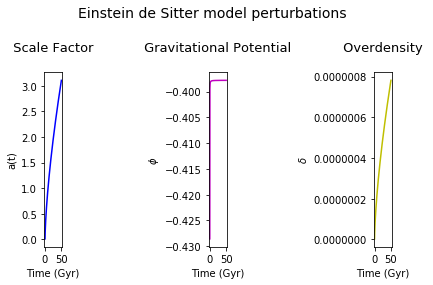

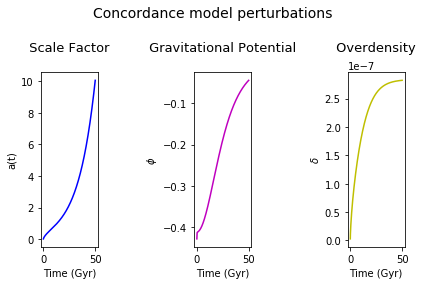

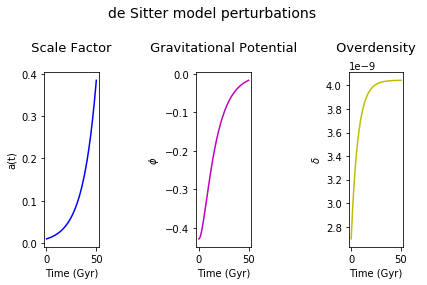

In [26]:
for i in range(len(models)):
        temp = models[i]
        Om, Ophi, name = temp[0], temp[1], temp[2]
        OM0, Lambda0, Gamma0, beta = 1., -1*math.pow(H0, 2)*Ophi*3, 0., 0.
        Eft = EFT(Om, Ophi, H0, a0, t0, it, dt)
        data = Eft.BackgroundTheory()[0]

        chi4 = ChiSq4params(data, t, H0, a0, t0, Om, Ophi, dt, name)
        chi4.plotting([0., OM0, 0., Lambda0, 0., Gamma0])

### Minimizing the Background Energy

In [27]:
if chirun == 1.:
    for i in range(len(models)):
            temp = models[i]
            Om, Ophi, name = temp[0], temp[1], temp[2]
            OM0, Lambda0, Gamma0, beta = 1., -1*math.pow(H0, 2)*Ophi*3, 1E-5, 0.
            Eft = EFT(Om, Ophi, H0, a0, t0, it, dt)
            data = Eft.BackgroundTheory()[0]
            chi4 = ChiSq4params(data, t, H0, a0, t0, Om, Ophi, dt, name)
            value = minimize(chi4, [0., OM0, 0., Lambda0, 0., Gamma0])
            print('Success for ', name, 'model ?: ', value.success, ' Parameters: ', value.x)
            print('Chi-Squared: ', value.fun)
            new = chi4.function(value.x)

            # Plotting the function
            plt.plot(t, new[0][0:len(t)], 'r', label = 'Minimised function')
            plt.plot(t, data, 'b', label = 'Lambda-CDM')
            plt.legend(loc = 2)
            plt.title('Expansion of the universe.')
            plt.ylabel('a(t)')
            plt.xlabel('time (Gyr)')
            plt.grid(True)
            plt.show()
